In [1]:
from data import get_cleaned_dataframes
from models import ttl_word2vec, classification

SpaCy pipeline loaded


load the preprocessed texts in all languages into a dataframe

In [4]:
cleaned_dataframe = get_cleaned_dataframes()

Split data into train and test sets

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_dataframe['cleaned_text'], cleaned_dataframe['label'] , test_size=0.3)

## Word2Vec
### Parameters:
- vector_size - vector size
- window - num of words before and after the focus word considered as context for the word
- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Train a Word2Vec model with the train set

In [5]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=X_train, vector_size= 100, window=5, min_count=2) # sentences = wikipedia articles!

save that model

In [6]:
model.save("../models/multilingual_word2vec.model")
# save model as KeyedVectors
wv = model.wv
wv.save('../models/word_vectors/multilingual_word2vec.kv')

load model

In [7]:
model = Word2Vec.load('../models/multilingual_word2vec.model')
wv = ttl_word2vec.load_word2vec_keyed_vectors('../models/word_vectors/multilingual_word2vec.kv')

Model:  ../models/word_vectors/multilingual_word2vec.kv  loaded


## Text Classification on manually trained Word2Vec model

### Create features from text for machine learning model.
Steps:
- Turn words in texts into word vectors.
- Method 1: averaging word vectors for each text

In [8]:
X_train_vect = classification.text2vec(X_train, wv)
X_test_vect = classification.text2vec(X_test, wv)

/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/models/classification.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_vect = np.array([np.array([keyed_vectors[i] for i in sentence if i in words])


In [9]:
X_train_vect_avg = classification.average_vector(X_train_vect)
X_test_vect_avg = classification.average_vector(X_test_vect)

### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correctly classified among that class
- f1-score: harmonic mean between precision and recall
- support: num of occurrence of given class in dataset

Instantiate and fit a basic Random Forest model on top of the vectors

In [10]:
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
classification.print_classification_report(y_test, y_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.94      0.85      0.89       217
    begnadet       0.11      0.25      0.15        16

    accuracy                           0.81       233
   macro avg       0.53      0.55      0.52       233
weighted avg       0.88      0.81      0.84       233

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.93      0.88      0.90       210
    begnadet       0.28      0.43      0.34        23

    accuracy                           0.83       233
   macro avg       0.61      0.66      0.62       233
weighted avg       0.87   

/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicahassibi/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

<AxesSubplot:ylabel='label'>

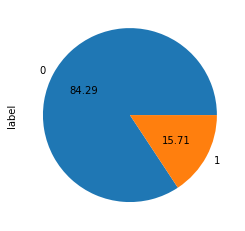

In [11]:
y_train.value_counts().plot.pie(autopct='%0.2f')

Highly Imbalanced Dataset!
Ideas:
- Undersampling: reduce majority class to make it equal to minority class
- Oversampling: increase minority class to make it equal to majority class through resampling
- K-fold cross validation

## Oversampling

In [12]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

<AxesSubplot:ylabel='label'>

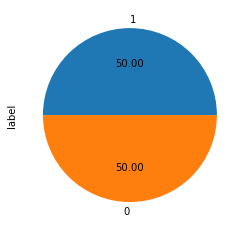

In [13]:
y_res.value_counts()
y_res.value_counts().plot.pie(autopct='%0.2f')

In [14]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

In [15]:
# classification with resampled vectors
X_res_vect = classification.text2vec(X_res_1d, wv)
X_res_vect_avg = classification.average_vector(X_res_vect)

/Users/jessicahassibi/PycharmProjects/bachelor-thesis/src/models/classification.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_vect = np.array([np.array([keyed_vectors[i] for i in sentence if i in words])


### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correclty classified among that class
- f1-score: harmonic mean between precision and recall
- support: num of occurence of given class in dataset

In [16]:
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
classification.print_classification_report(y_test, y_res_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.89      0.88      0.88       201
    begnadet       0.31      0.34      0.32        32

    accuracy                           0.80       233
   macro avg       0.60      0.61      0.60       233
weighted avg       0.81      0.80      0.81       233

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.41      0.90      0.56        90
    begnadet       0.75      0.19      0.30       143

    accuracy                           0.46       233
   macro avg       0.58      0.54      0.43       233
weighted avg       0.62   